<a href="https://colab.research.google.com/github/rondinell/rondinelli/blob/main/C%C3%B3pia_de_trading_com_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Como criar uma estratégia de trading com Python

### Indicador usado: RSI

### Estratégia:

Vamos comprar a ação sempre que o RSI for menor do que 30.

Será que dá dinheiro?

# Passo a Passo:


* Passo 1: Escolher um ativo.
* Passo 2: Puxar os dados de cotações no Yahoo finance.
* Passo 3: Calcular os retornos positivos e negativos.
* Passo 4: Separar os retornos positivos dos negativos.
* Passo 5: Calcular a média dos retornos positivos e negativos nos últimos 22 dias
* Passo 6: Calcular o RSI
* Passo 7: Gerar os sinais de compra ou venda
* Passo 8: Observando pontos de compra ao longo do tempo
* Passo 9: Calculando lucros
* Passo 10: Analisando lucros
<br>

    * Qual a média de lucros?
    * Qual a média de perdas?
    * Qual a % de operações vencedoras?
    * Qual expectativa matemática do modelo?
    * Qual retorno acumulado?
    * O retorno acumulado venceu o Buy and Hold na ação?


### Fórmula RSI:

$100 - 100/(1 + mediaRetornosPositivos / mediaRetornosNegativos)$

In [267]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

pd.options.mode.chained_assignment = None

# Passo 1: Escolher um ativo

In [268]:
ativo = ['PETR4.SA']

# Passo 2: Puxar os dados do Yahoo Finance

In [269]:
dados_ativo = yf.download(ativo)

dados_ativo

#tome cuidado com ações muito antigas! As vezes vão ter os dados mas com volume zero.
#Pegue um período que tenha volume

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA
Date,,,,,
2000-01-03,1.283870,1.283870,1.283870,1.283870,35389440000
2000-01-04,1.212848,1.212848,1.212848,1.212848,28861440000
2000-01-05,1.200610,1.200610,1.200610,1.200610,43033600000
2000-01-06,1.196458,1.196458,1.196458,1.196458,34055680000
2000-01-07,1.201921,1.201921,1.201921,1.201921,20912640000
...,...,...,...,...,...
2025-03-24,36.750000,36.939999,36.500000,36.700001,20348000
2025-03-25,37.040001,37.520000,36.630001,36.849998,28036100


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


<Axes: xlabel='Date'>

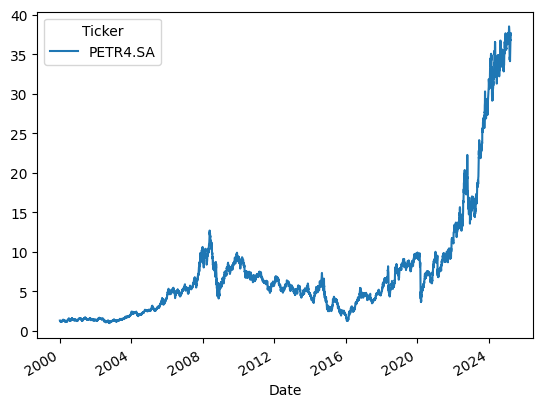

In [270]:
dados_ativo['Close'].plot()

# Passo 3: Calcular os retornos

In [274]:
for ticker in ativo:
    dados_ativo[f'retornos_{ticker}'] = dados_ativo['Close'][ticker].pct_change().dropna()

# Passo 4: Separar os retornos positivos dos negativos

In [275]:
retorno = 2

filtrando_retorno = lambda x: x if x > 0 else 0

filtrando_retorno(retorno)

2

**Passo 5: Calcular a média dos retornos positivos e negativos nos últimos 22 dias **negrito**



In [273]:
for ticker in ativo:
    dados_ativo[f'retornos_{ticker}'] = dados_ativo['Close'][ticker].pct_change().dropna()
    # The following lines were incorrectly indented
    dados_ativo[f'retornos_postivos'] = dados_ativo[f'retornos_{ticker}'].apply(lambda x: x if x > 0 else 0)
    dados_ativo[f'retornos_negativos'] = dados_ativo[f'retornos_{ticker}'].apply(lambda x: abs(x) if x < 0 else 0)
    dados_ativo[f'media_retornos_positivos_{ticker}'] = dados_ativo[f'retornos_postivos'].rolling(22).mean()  # Using a 22-day rolling average
    dados_ativo[f'media_retornos_negativos_{ticker}'] = dados_ativo[f'retornos_negativos'].rolling(22).mean()  # Using a 22-day rolling average

# Passo 6: Calcular o RSI

### Fórmula RSI:

$100 - 100/(1 + mediaRetornosPositivos / mediaRetornosNegativos)$

In [276]:
dados_ativo[f'RSI_{ticker}'] = (100 - 100 / (1 + dados_ativo[f'media_retornos_positivos_{ticker}'] / dados_ativo[f'media_retornos_negativos_{ticker}']))

# Passo 7: Sinais de compra ou venda

In [278]:
dados_ativo.loc[dados_ativo[f'RSI_{ticker}'] < 30, 'compra'] = 'sim'  # Use f-string for RSI column
dados_ativo.loc[dados_ativo[f'RSI_{ticker}'] > 30, 'compra'] = 'nao'  # Use f-string for RSI column

# A gente vai ter 2 stops de venda:

* RSI acima de 40
* 10 dias de operação

In [279]:
data_compra = []
data_venda = []

for i in range(len(dados_ativo) - 11):  # Subtracting 11 to avoid exceeding DataFrame bounds
    # Check if 'compra' value is a string before using 'in' operator
    if isinstance(dados_ativo['compra'].iloc[i], str) and "sim" in dados_ativo['compra'].iloc[i]:
        data_compra.append(dados_ativo.iloc[i+1].name) # +1 porque a gente compra no preço de abertura do dia seguinte.

        for j in range(1, 11):
            # Accessing the correct RSI column using f-string
            if dados_ativo[f'RSI_{ticker}'].iloc[i + j] > 70: #vendo se nos proximos 10 dias o RSI passa de 40
                data_venda.append(dados_ativo.iloc[i + j + 1].name) #vende no dia seguinte q bater 40
                break

            elif j == 10:
                data_venda.append(dados_ativo.iloc[i + j + 1].name)

# Passo 8: Observando pontos de compra ao longo do tempo

Text(0.5, 0, 'Data')

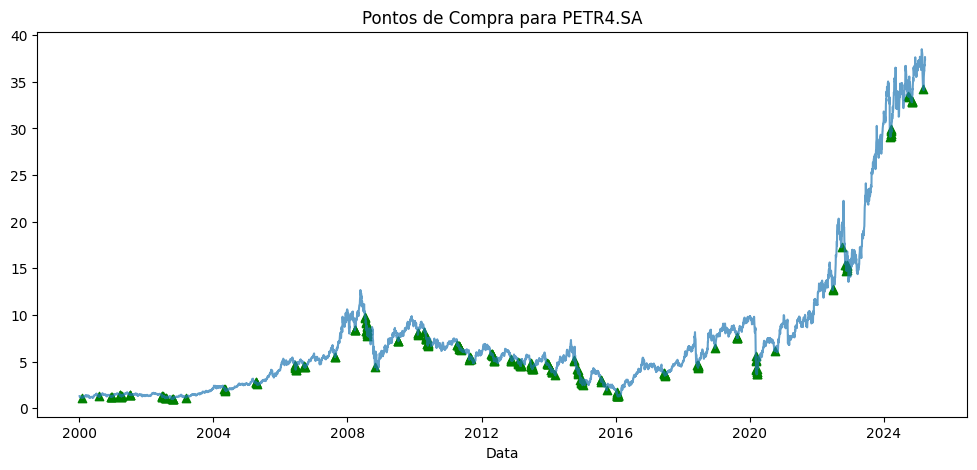

In [280]:
data_compra = dados_ativo.index[dados_ativo['compra'] == 'sim']

# Plotting the data
plt.figure(figsize=(12, 5))
plt.scatter(
    data_compra,
    dados_ativo.loc[data_compra]['Close'][ticker],  # Access 'Close' values only for the current ticker
    marker='^',
    c='g',
)
plt.plot(dados_ativo.index, dados_ativo['Close'][ticker], alpha=0.7) # Plot 'Close' values for the current ticker
plt.title(f'Pontos de Compra para {ticker}') # Add a title to the plot for clarity
plt.xlabel('Data')

# Passo 9: Calculando lucros

In [281]:
lucros = dados_ativo.loc[data_venda]['Open'].values/dados_ativo.loc[data_compra]['Open'].values - 1

lucros

array([[ 0.10346138],
       [ 0.11470866],
       [-0.03725445],
       [-0.00688747],
       [ 0.08695703],
       [ 0.11856803],
       [-0.10046011],
       [-0.13056075],
       [-0.097466  ],
       [ 0.06054255],
       [ 0.08315794],
       [ 0.09788668],
       [ 0.15239121],
       [ 0.07991402],
       [ 0.00483085],
       [-0.01915711],
       [ 0.02499977],
       [-0.03504087],
       [-0.04106775],
       [ 0.00173119],
       [ 0.06087937],
       [ 0.03378066],
       [ 0.08536579],
       [ 0.06919371],
       [ 0.04556942],
       [ 0.12095936],
       [ 0.17966555],
       [ 0.16763433],
       [ 0.23579538],
       [ 0.13257029],
       [-0.08496743],
       [-0.02435748],
       [-0.0505636 ],
       [ 0.03488216],
       [-0.06568599],
       [-0.09241429],
       [-0.06323544],
       [-0.01052621],
       [-0.00667018],
       [-0.00072841],
       [ 0.03089699],
       [ 0.08799979],
       [ 0.12971492],
       [ 0.18493165],
       [ 0.08558437],
       [-0

# Passo 10: Analisando lucros


* Qual a média de lucros?
* Qual a média de perdas?
* Qual a % de operações vencedoras?
* Qual expectativa matemática do modelo?
* Qual retorno acumulado?
* O retorno acumulado venceu o Buy and Hold na ação?

In [282]:
operacoes_vencedoras = len(lucros[lucros > 0])/len(lucros)

operacoes_vencedoras

0.49800796812749004

In [283]:
media_ganhos = np.mean(lucros[lucros > 0])

media_ganhos * 100

np.float64(8.660790706482627)

In [285]:
media_perdas = abs(np.mean(lucros[lucros < 0]))

media_perdas

np.float64(0.059396004165896424)

In [286]:
expectativa_matematica_modelo = (operacoes_vencedoras * media_ganhos) - ((1 - operacoes_vencedoras) * media_perdas)

expectativa_matematica_modelo * 100

np.float64(1.3315107004782205)

In [287]:
performance_acumulada = (np.cumprod((1 + lucros)) - 1)
performance_acumulada*100

array([ 10.34613817,  23.00379626,  18.42135765,  17.60573461,
        27.83238052,  42.98921416,  28.6245024 ,  11.83119038,
         0.93145129,   7.04209825,  15.94349842,  27.29282233,
        46.69112911,  58.41380642,  59.17907901,  56.12966742,
        60.03287292,  54.42518107,  48.08328594,  48.33964565,
        57.37047043,  62.68654938,  76.57441532,  88.79225468,
        97.39540744, 121.27222923, 161.02722597, 204.78435026,
       276.65109057, 326.58383314, 290.33810006, 280.83044638,
       261.57428747, 274.1867785 , 249.6079508 , 217.29917989,
       197.23462538, 194.10587271, 192.14413445, 191.93133279,
       200.95113082, 227.43476669, 269.90794197, 338.31562815,
       375.82859344, 345.10368761, 328.92814297, 340.75334551,
       350.72005955, 404.01859176, 473.46340834, 504.16961318,
       601.77651625, 684.33213076, 580.63436719, 479.45219885,
       418.01488955, 370.42681139, 338.50039407, 336.43453316,
       311.98838436, 278.47625024, 268.77168872, 236.07

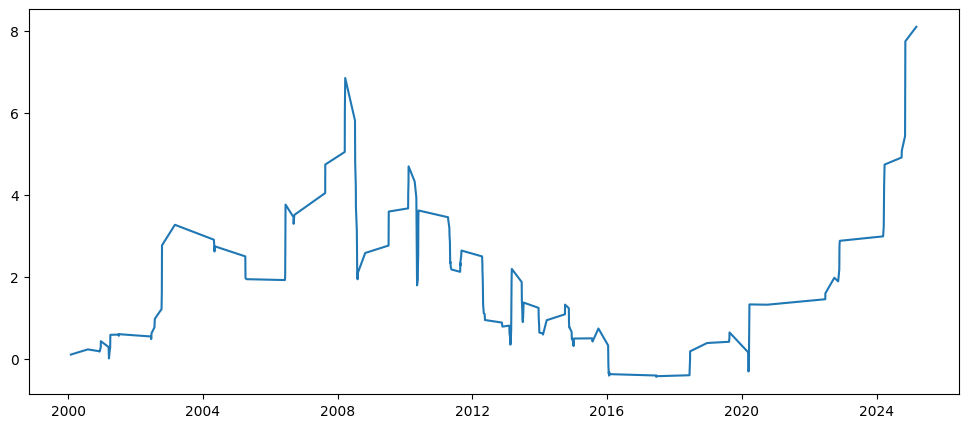

In [288]:
plt.figure(figsize = (12, 5))
plt.plot(data_compra, performance_acumulada)

In [291]:
retorno_buy_and_hold = dados_ativo['Close'].iloc[-1]/dados_ativo['Close'].iloc[0] - 1

retorno_buy_and_hold * 100

,0
Ticker,
PETR4.SA,2815.404814
